In [19]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from collections import Counter
from wordcloud import WordCloud

nltk.download('stopwords')

class SMSDataProcessor:
    def __init__(self):
        self.stop_words_set = set(stopwords.words('english'))

    def read_sms_data(self, file_path):
        """Load SMS data from a given file path"""
        try:
            dataset = pd.read_csv(file_path, sep='\t', names=['category', 'text'])

            print("\nDataset Overview:")
            print(dataset.head())

            # Convert labels to lowercase and validate
            dataset['category'] = dataset['category'].str.lower()
            if not set(dataset['category']).issubset({'ham', 'spam'}):
                raise ValueError("Labels must be 'ham' or 'spam'")

            # Encode labels: 'spam' -> 1, 'ham' -> 0
            dataset['category'] = (dataset['category'] == 'spam').astype(int)

            # Handle missing values
            if dataset.isnull().sum().any():
                print("\nMissing values detected. Replacing with empty strings.")
                dataset['text'].fillna('', inplace=True)

            print("\nDataset Statistics:")
            print(dataset['category'].value_counts(normalize=True))

            return dataset

        except Exception as err:
            print(f"Error loading file: {err}")
            raise

    def preprocess_text(self, msg):
        """Clean SMS text by removing special characters and stopwords"""
        try:
            if pd.isna(msg) or msg.strip() == '':
                return 'empty_msg'

            msg = msg.lower()
            msg = re.sub(r'[^a-z\s]', ' ', msg)
            msg = ' '.join(msg.split())

            words = msg.split()
            words = [word for word in words if word not in self.stop_words_set]
            cleaned_msg = ' '.join(words)

            return cleaned_msg if cleaned_msg else 'empty_msg'
        except Exception as err:
            print(f"Error in text cleaning: {err}")
            return 'error_cleaning'

    def remove_redundant_messages(self, dataset):
        """Remove duplicate SMS messages"""
        before_count = len(dataset)
        dataset = dataset.drop_duplicates(subset=['text'])
        after_count = len(dataset)
        print(f"Removed {before_count - after_count} duplicate messages")
        return dataset

    def filter_outliers(self, dataset):
        """Remove extreme length SMS messages"""
        dataset['msg_length'] = dataset['text'].str.len()
        Q1 = dataset['msg_length'].quantile(0.25)
        Q3 = dataset['msg_length'].quantile(0.75)
        IQR = Q3 - Q1
        dataset = dataset[
            (dataset['msg_length'] >= Q1 - 1.5 * IQR) &
            (dataset['msg_length'] <= Q3 + 1.5 * IQR)
        ]
        dataset.drop(columns=['msg_length'], inplace=True)
        return dataset

    def visualize_data(self, dataset):
        """Perform Exploratory Data Analysis (EDA)"""
        print("\nGenerating Visualizations...")
        dataset['text_length'] = dataset['text'].str.len()

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Label Distribution
        sns.countplot(x='category', data=dataset, ax=axes[0])
        axes[0].set_title('Message Category Distribution')

        # Message Length Boxplot
        sns.boxplot(x='category', y='text_length', data=dataset, ax=axes[1])
        axes[1].set_title('Message Length by Category')

        # Word Frequency Analysis
        spam_words = ' '.join(dataset[dataset['category'] == 1]['text']).split()
        ham_words = ' '.join(dataset[dataset['category'] == 0]['text']).split()

        spam_freq = Counter(spam_words)
        ham_freq = Counter(ham_words)

        common_spam = pd.DataFrame(spam_freq.most_common(10), columns=['word', 'count'])
        common_ham = pd.DataFrame(ham_freq.most_common(10), columns=['word', 'count'])

        common_spam.plot(kind='bar', x='word', y='count', ax=axes[2], color='red', alpha=0.7, label='Spam')
        common_ham.plot(kind='bar', x='word', y='count', ax=axes[2], color='blue', alpha=0.7, label='Ham')

        axes[2].set_title('Top 10 Frequent Words')
        axes[2].legend()

        plt.tight_layout()
        plt.savefig('eda_analysis.png')
        plt.close()

        dataset.drop(columns=['text_length'], inplace=True)
        return dataset

    def feature_engineering(self, dataset):
        """Prepare and clean messages"""
        print("\nProcessing text messages...")
        dataset['clean_text'] = dataset['text'].apply(self.preprocess_text)

        empty_msgs = dataset['clean_text'].str.strip() == ''
        if empty_msgs.any():
            print(f"Warning: {empty_msgs.sum()} empty messages detected. Filling with 'empty_msg'.")
            dataset.loc[empty_msgs, 'clean_text'] = 'empty_msg'

        print("\nSample Processed Messages:")
        print(dataset[['text', 'clean_text']].head())

        return dataset

    def split_dataset(self, dataset, train_size=0.7, val_size=0.15):
        """Split data into training, validation, and test sets"""
        print("\nSplitting Dataset...")

        train_set, temp_set = train_test_split(
            dataset, train_size=train_size, stratify=dataset['category'], random_state=42
        )
        val_ratio = val_size / (1 - train_size)
        val_set, test_set = train_test_split(
            temp_set, train_size=val_ratio, stratify=temp_set['category'], random_state=42
        )

        print(f"Train: {len(train_set)}, Validation: {len(val_set)}, Test: {len(test_set)}")
        return train_set, val_set, test_set

    def correlation_analysis(self, dataset):
        """Analyze correlation of text features with category"""
        dataset['char_count'] = dataset['clean_text'].str.len()
        dataset['word_count'] = dataset['clean_text'].str.split().str.len()
        dataset['avg_word_size'] = dataset['char_count'] / dataset['word_count']

        correlations = dataset[['char_count', 'word_count', 'avg_word_size', 'category']].corr()['category']

        plt.figure(figsize=(10, 5))
        correlations.drop('category').plot(kind='bar', color='purple')
        plt.title('Feature Correlation with Spam Label')
        plt.show()

        return dataset
    def generate_wordclouds(self, dataset):
        """Generate WordClouds for spam and ham messages"""
        spam_text = ' '.join(dataset[dataset['category'] == 1]['clean_text'])
        ham_text = ' '.join(dataset[dataset['category'] == 0]['clean_text'])

        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        spam_wc = WordCloud(width=500, height=300, background_color='black').generate(spam_text)
        ham_wc = WordCloud(width=500, height=300, background_color='white').generate(ham_text)

        axes[0].imshow(spam_wc, interpolation='bilinear')
        axes[0].set_title("WordCloud - Spam Messages")
        axes[0].axis('off')

        axes[1].imshow(ham_wc, interpolation='bilinear')
        axes[1].set_title("WordCloud - Ham Messages")
        axes[1].axis('off')

        plt.tight_layout()
        plt.savefig('wordclouds.png')
        plt.show()

    def plot_pie_chart(self, dataset):
        """Plot a pie chart of spam vs. ham distribution"""
        plt.figure(figsize=(6, 6))
        dataset['category'].value_counts().plot.pie(
            autopct='%1.1f%%',
            labels=['Ham', 'Spam'],
            colors=['blue', 'red'],
            explode=[0.1, 0.1],
            startangle=90
        )
        plt.title('Spam vs Ham Distribution')
        plt.savefig('pie_chart.png')
        plt.show()

    def plot_histograms(self, dataset):
        """Plot histograms for text length and word count"""
        dataset['char_count'] = dataset['clean_text'].str.len()
        dataset['word_count'] = dataset['clean_text'].str.split().str.len()

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        sns.histplot(dataset, x='char_count', hue='category', bins=30, kde=True, ax=axes[0])
        axes[0].set_title('Character Count Distribution')

        sns.histplot(dataset, x='word_count', hue='category', bins=30, kde=True, ax=axes[1])
        axes[1].set_title('Word Count Distribution')

        plt.tight_layout()
        plt.savefig('histograms.png')
        plt.show()

    def generate_pairplot(self, dataset):
        """Create a pairplot for numerical features"""
        numeric_features = dataset[['char_count', 'word_count', 'category']]
        sns.pairplot(numeric_features, hue='category', diag_kind='kde', palette={0: 'blue', 1: 'red'})
        plt.suptitle("Pairplot of Numeric Features", fontsize=14)
        plt.savefig('pairplot.png')
        plt.show()    

    def execute_visualizations(self, dataset):
        """Run all visualization functions"""
        print("\nGenerating WordClouds...")
        self.generate_wordclouds(dataset)

        print("\nGenerating Pie Chart...")
        self.plot_pie_chart(dataset)

        print("\nGenerating Histograms...")
        self.plot_histograms(dataset)

        print("\nGenerating Pairplot...")
        self.generate_pairplot(dataset)
        
    def execute_pipeline(self, file_path):
        """Run full data processing pipeline"""
        print("Starting Data Processing...")

        dataset = self.read_sms_data(file_path)
        dataset = self.remove_redundant_messages(dataset)
        dataset = self.filter_outliers(dataset)
        dataset = self.visualize_data(dataset)
        dataset = self.feature_engineering(dataset)
        dataset = self.correlation_analysis(dataset)
        self.execute_visualizations(dataset)
        train_set, val_set, test_set = self.split_dataset(dataset)
        train_set.to_csv('train.csv',index=False)
        val_set.to_csv('validation.csv',index=False)
        test_set.to_csv('test.csv',index=False)
        return train_set, val_set, test_set


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chaud\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Starting Data Processing...

Dataset Overview:
  category                                               text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...

Dataset Statistics:
category
0    0.865937
1    0.134063
Name: proportion, dtype: float64
Removed 403 duplicate messages

Generating Visualizations...


C:\Users\chaud\AppData\Local\Temp\ipykernel_7844\2816639471.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns=['msg_length'], inplace=True)



Processing text messages...

Sample Processed Messages:
                                                text  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                          clean_text  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry wkly comp win fa cup final tkts st ...  
3                u dun say early hor u c already say  
4             nah think goes usf lives around though  


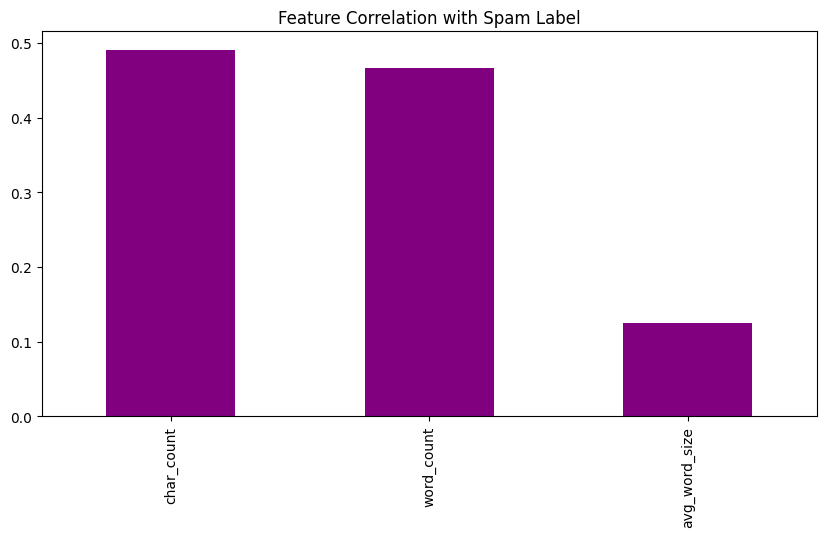


Generating WordClouds...


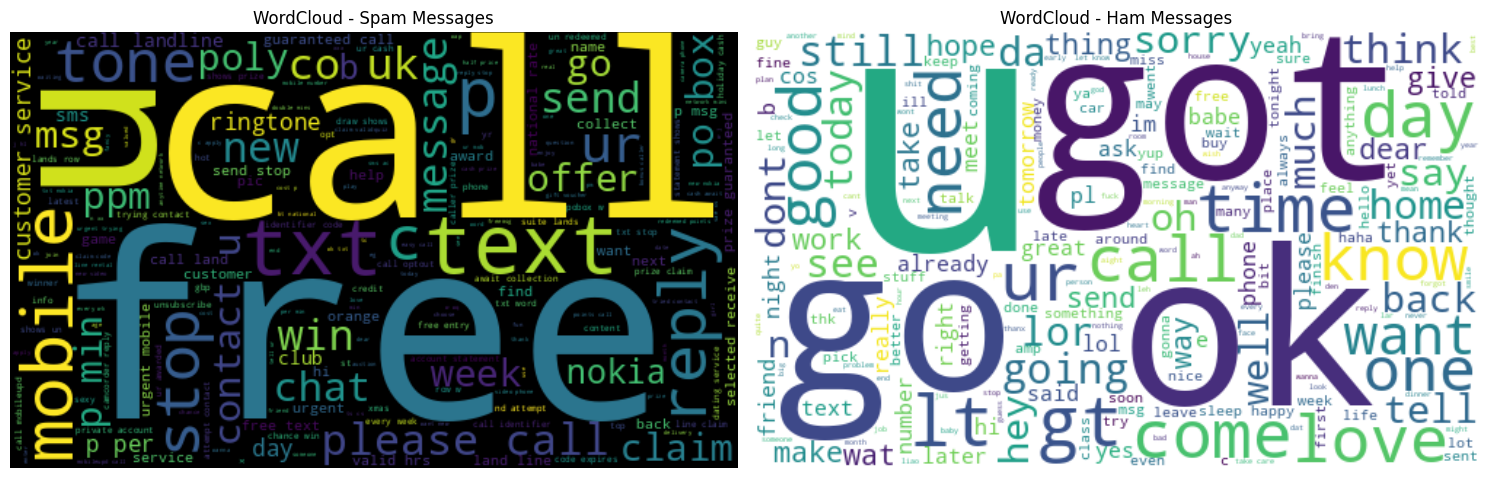


Generating Pie Chart...


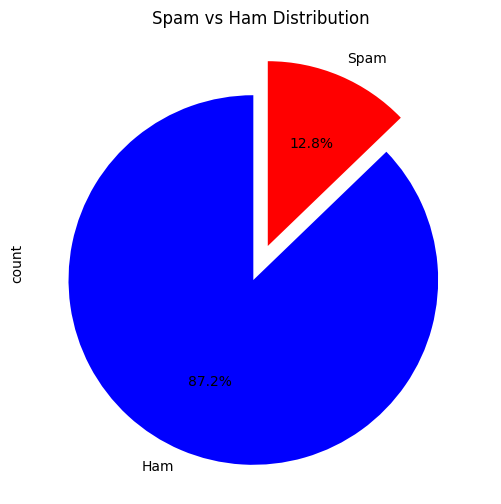


Generating Histograms...


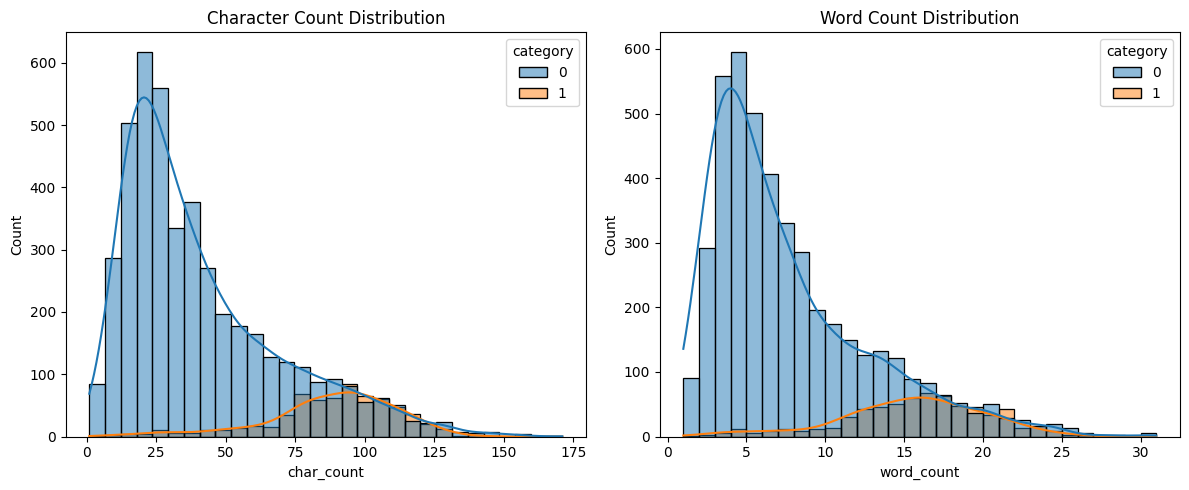


Generating Pairplot...


C:\Users\chaud\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


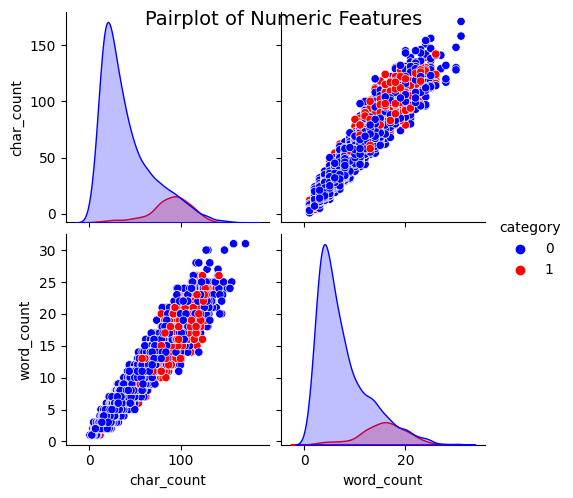


Splitting Dataset...
Train: 3573, Validation: 765, Test: 767


In [20]:
data_prep = SMSDataProcessor()
train_df, val_df, test_df = data_prep.execute_pipeline("SMSSpamCollection")